# Long Short Term Memory (LSTM) Model

LSTMs are variations of recurrent neural networks.

*Acknowledgments:* Presented with [help](https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning) and [more help](https://github.com/kshitij-raj/Stock-Price-Prediction-LSTM).

In [58]:
## Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import  EarlyStopping
from keras import optimizers

In [59]:
## Load, preprocess data
df = pd.read_csv('./TSLA.csv')

# We will train on closing prices
df = df.reset_index()['Close']
sc = MinMaxScaler()
df = sc.fit_transform(np.array(df).reshape(-1,1))
train, test = train_test_split(df, test_size = 0.2, shuffle = False)


# Modify training, testing data with timesteps
def create_timeseries(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[(i + time_step), 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_timeseries(train, time_step)
X_test, y_test = create_timeseries(test, time_step)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [70]:
## Build and fit LSTM
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (time_step, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

In [61]:
optimizer = optimizers.Adam(learning_rate = 0.01)

model.compile(loss = 'mean_squared_error', optimizer = optimizer)

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto', verbose = 1)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100,
                    batch_size = 64, verbose = 1, callbacks = [early_stop])

Epoch 1/100
35/35 [==============================] - 2s 67ms/step - loss: 0.0016 - val_loss: 0.1606
Epoch 2/100
35/35 [==============================] - 2s 48ms/step - loss: 1.4761e-04 - val_loss: 0.0694
Epoch 3/100
35/35 [==============================] - 2s 48ms/step - loss: 1.7996e-05 - val_loss: 0.0583
Epoch 4/100
35/35 [==============================] - 2s 48ms/step - loss: 1.2852e-05 - val_loss: 0.0549
Epoch 5/100
35/35 [==============================] - 2s 47ms/step - loss: 1.3901e-05 - val_loss: 0.0576
Epoch 6/100
35/35 [==============================] - 2s 47ms/step - loss: 1.1675e-05 - val_loss: 0.0539
Epoch 7/100
35/35 [==============================] - 2s 49ms/step - loss: 1.2126e-05 - val_loss: 0.0543
Epoch 8/100
35/35 [==============================] - 2s 55ms/step - loss: 1.3957e-05 - val_loss: 0.0502
Epoch 9/100
35/35 [==============================] - 2s 63ms/step - loss: 1.1871e-05 - val_loss: 0.0517
Epoch 10/100
35/35 [==============================] - 2s 53ms/step -

In [62]:
##Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Invert transformation to get stock prices
train_pred = sc.inverse_transform(train_pred)
test_pred = sc.inverse_transform(test_pred)

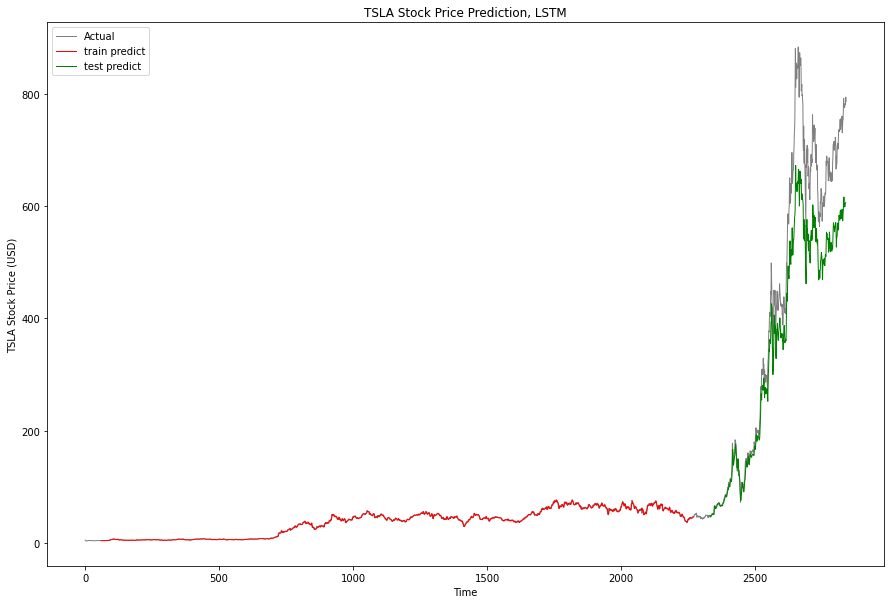

In [71]:
## Observed v. Predicted Results
# Shift train prediction for plotting
look_back = time_step
train_pred_plot = np.empty_like(df)
train_pred_plot[:, :] = np.nan
train_pred_plot[look_back: len(train_pred) + look_back, :] = train_pred

# Shift test prediction for plotting
test_pred_plot = np.empty_like(df)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred) + (look_back * 2) + 1: len(df) -1, :] = test_pred

plt.figure(figsize = (15, 10))
plt.plot(sc.inverse_transform(df), color = 'gray', linewidth = 1, label = 'Actual')
plt.plot(train_pred_plot, linewidth = 1, color = 'red', label = 'Train Predict')
plt.plot(test_pred_plot, linewidth = 1, color = 'green', label = 'Test Predict')
plt.legend()
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price (USD)')
plt.title('TSLA Stock Price Prediction, LSTM')
plt.show()